In [1]:
import sys
import stmpy
import numpy as np
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import pandas as pd
import scipy.fftpack as fftp
import os
from scipy import signal
import scipy
import matplotlib.pyplot as plt
import time
import gc
%pylab inline

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
# folder_loc = '2020-03-13/Chirp Calibration v2/'
# file_loc = '2020-03-13-18-01_chirp2_cal001.dat'
folder_loc = '2020-03-13/Chirp Calibration Lockin/'
file_loc = '2020-03-13-19-41_chirp_lockin_cal001.dat'
dat = np.loadtxt(folder_loc+file_loc,skiprows=76)

for filename in os.listdir(folder_loc):
    if filename == file_loc:
        pass
    try:
        tempdata = np.loadtxt(folder_loc+filename, skiprows=76)
        dat = np.concatenate((dat,tempdata))
        print(filename,end='\r')
    except:
        print('ERROR: ',filename)

In [3]:
cur = dat[:,0]
geo = dat[:,1]
chirp = dat[:,2]
geo_in = dat[:,3]
tip = dat[:,6]
LIY = dat[:,8]

# chirp = dat[:,2]
# Z = dat[:,5]
# geo = dat[:,1]
# cur = dat[:,0]
# geo = dat[:,0]
# chirp = dat[:,1]
# Z = dat[:,2]
# print(shape(dat))
t = linspace(0,len(chirp)/10000,len(chirp))
print(t[-1])

2057.4


In [4]:
# figsize(15,6)
# plot(t,cur)
# xlim(800,900)
# ylim(0,2e-9)

In [5]:
# fig,ax = subplots(figsize=[15,12])

# # ax = subplot(111)
# # im = imshow(transf_2d_show, cmap=stmpy.cm.cividis, aspect=1, clim=(0,0.1),rasterized=True)
# fs = 10000
# f, t_spt, Sxx = signal.spectrogram(cur, fs,nperseg=50000)

# im1 = ax.pcolormesh(t_spt,f,log(Sxx),cmap=stmpy.cm.cividis,vmin=-70,vmax=-40)
# cb = stmpy.image.add_cbar(thickness='5%',length='65%',hPos=0.93)
# # cb.set_label('colorbar label', color='w')
# # plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='r')
# ax.axes.set_xticklabels((t_spt[::52]/60).astype('int'),color='w')
# ax.axes.set_yticklabels(['0','100','200','300','400','500'],color='w')
# ax.axes.tick_params(labelsize=18,color='white')
# ax.set_xlabel('Time (min)',size=38,color='white')
# ax.set_ylabel('Current Frequency (Hz)',size=38,color='white')
# ax.set_ylim(0,500)
# savefig('Current Chirp Spectrogram',transparent= True)

In [7]:
# print(len(t_spt))
plt.style.use('seaborn-darkgrid')
# figsize(15,6)
# plot(t,chirp)

In [8]:
# fs = 10000
# freq = 400
# period = int((1/freq)*fs)
# wave = reshape(cos(freq*2*pi*t[-200000:])+1j*sin(freq*2*pi*t[-200000:]),(period,-1))
# chirp_temp = reshape(np.copy(chirp[-200000:]),(period,-1))
# lock_in = zeros(len(chirp_temp[0,:]),dtype=np.complex)
# print(shape(chirp_temp))
# for i,val in enumerate(chirp_temp[0,:]):
#     print(i,end='\r')
#     lock_wave = wave[:,i]*chirp_temp[:,i]
# #     print(len(lock_wave))
#     sos = signal.butter(10,freq/5,'lowpass',fs=fs,output='sos')
#     lock_in[i] = mean(signal.sosfiltfilt(sos,lock_wave))

    
    
# %reset_selective -f wave
# %reset_selective -f chirp_temp

In [9]:
# sos = signal.butter(10,400/5,'lowpass',fs=fs,output='sos')
# plot(t[-200000:],chirp[-200000:])
# plot(t[-200000:],(sin(400*2*pi*t[-200000:]))*chirp[-200000:])
# plot(t[-200000:],signal.sosfiltfilt(sos,(sin(400*2*pi*t[-200000:]))*chirp[-200000:]))     
# # plot(t[-200000::200],0.1*lock_in,'.')
# plot(t[-200000:],0.07+0*chirp[-200000:])
# xlim(2039,2040)
# ylim(0.05,0.1)


In [10]:
fs = 10000
start = int(38.65*fs)
end = int(2039.7*fs)

cur = dat[start:end,0]
geo = dat[start:end,1]
chirp = dat[start:end,2]
geo_in = dat[start:end,3]
tip = dat[start:end,6]
LIY = dat[start:end,8]

t = linspace(0,len(chirp)/10000,len(chirp))

In [11]:
# plot(cur)

In [12]:
def fit_cancel(array, n=1):
    t=linspace(0,len(array),len(array))
    fit = polyfit(t,array,n)
    corrective = fit[n]*ones(shape(t))
    for j in arange(n):
        corrective += fit[j]*(t**(n-j))
    return array - corrective

def cancel_skips(array, tol):
    data = array[15:]-array[:-15]
    markers = where(abs(data)>=tol)*sign(data)[where(abs(data)>=tol)]
    result = array[0:abs(int(markers[0][0]))]
    counter=markers[0][0]
    gap = 0
    for idx in markers[0]:
        if (counter*idx) < 1:
            result = concatenate((result,array[abs(int(counter)):abs(int(idx))]-gap))
            counter = idx
            gap = 0
        else:
            if markers[0][0] > 0: gap = max(gap,data[abs(int(idx))])
            else: gap = min(gap,data[abs(int(idx))])
    if shape(array) is not shape(result):
        result = concatenate((result,array[abs(int(counter)):]-gap))
    return result

In [13]:
tip_temp = tip-mean(tip)
tip_temp[18697800:] = 2e-10+tip_temp[18697800:]
tip_fit = fit_cancel(tip_temp,n=3)
%reset_selective -f tip_temp

In [14]:
# tip_temp = tip-mean(tip)
# tip_temp[18697800:] = 2e-10+tip_temp[18697800:]
# plot(t,tip-mean(tip),label='Raw')
# # xlim(18696500,18698000)
# plot(t,tip_fit,label='Thermal drift removed')
# xlabel('Time (secs)',size=15)
# ylabel('Amplitude (m)',size=15)
# legend(loc=1,fontsize=12)

In [15]:
loc = linspace(0,len(t),10000).astype('int')

In [16]:
def coef(w,geo,tip,t_array,harmonic,fs=1000):
    
    if w*harmonic >= fs/2:
        return 0 + 0*1j
    
    ref_tip = tip*(np.cos(w*harmonic*2*pi*t_array)-1j*sin(w*harmonic*2*pi*t_array)) 
    ref_geo = geo*(np.cos(w*2*pi*t_array)-1j*sin(w*2*pi*t_array))
    
    sos = signal.butter(10, w/5, 'lowpass', fs=fs, output='sos')
    
    filt_tip = signal.sosfiltfilt(sos,ref_tip)
    filt_geo = signal.sosfiltfilt(sos,ref_geo)
    
    
    lock_tip = average(filt_tip)
    lock_geo = average(filt_geo)
    Z = lock_tip/lock_geo
    
    return Z

prev = 0
harmonics = 10
steps = 10000
loc = linspace(60272,len(t),int(steps/30 -1)).astype('int')
# loc = (change_loc*fs).astype('int')
freq_map = linspace(50,400,len(loc))
fftfreq = fft.fftfreq(int(10000/(freq_map[1]-50)),1/10000)
# print(np.where(absolute(fftfreq-400) <0.1))

C = np.zeros((len(fftfreq),harmonics),dtype='complex128')

for w,point,i in zip(freq_map,loc,arange(len(freq_map))):
    i = i+48
    print(w,end='\r')
    input_wave = geo[prev:point]
    output_wave = tip_fit[prev:point]
    t_split = t[prev:point]
    for j in arange(harmonics):
        C[i,j] = coef(w,input_wave,output_wave,t_split,(j+1),fs = 10000)
        
    prev = point
    
C[int(len(C[:,0])/2):,:] = flip(conj(C[1:int(len(C[:,0])/2)+2]),axis=0)

In [17]:
C1 = scipy.interpolate.interp1d(fftfreq,C[:,0], kind='linear',fill_value='extrapolate')
C2 = scipy.interpolate.interp1d(fftfreq,C[:,1], kind='linear',fill_value='extrapolate')
C3 = scipy.interpolate.interp1d(fftfreq,C[:,2], kind='linear',fill_value='extrapolate')
C4 = scipy.interpolate.interp1d(fftfreq,C[:,3], kind='linear',fill_value='extrapolate')
C5 = scipy.interpolate.interp1d(fftfreq,C[:,4], kind='linear',fill_value='extrapolate')
C6 = scipy.interpolate.interp1d(fftfreq,C[:,5], kind='linear',fill_value='extrapolate')

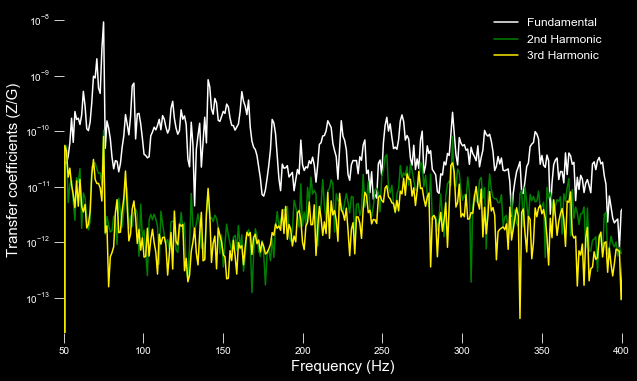

In [135]:
figsize(10,6)

# print(freq_map[1]-50)
# print(fftfreq[379])

fig,ax=subplots(1,1)

semilogy(fftfreq,absolute(C[:,0]),'w',label='Fundamental    ')
semilogy(fftfreq,absolute(C[:,1]),'g',label='2nd Harmonic')
semilogy(fftfreq,absolute(C[:,2]),'#ffef00',label='3rd Harmonic')
xlim(50,400)
tick_params(size= 10)
grid(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')
xlabel('Frequency (Hz)',size=15)
ylabel('Transfer coefficients (Z/G)',size = 15)
legend(loc=1,fontsize=12)
savefig('2020-3-13 Matrix coefficients')

In [19]:
folder_loc = '2020-03-13/Noisy Calibration Lockin 170/'
file_loc = '2020-03-13-21-40_noisy170_lockin_cal001.dat'
dat = np.loadtxt(folder_loc+file_loc,skiprows=76)

for filename in os.listdir(folder_loc):
    if filename == file_loc:
        pass
    try:
        tempdata = np.loadtxt(folder_loc+filename, skiprows=76)
        dat = np.concatenate((dat,tempdata))
        print(filename,end='\r')
    except:
        print('ERROR: ',filename)

In [42]:
cur_test = dat[:,0]
geo_test = dat[:,1]
# geo_in_test = dat[:,3]
tip_test = dat[:,8]
print(len(cur_test)/10000)

777.74


In [26]:
tip_fit_test = fit_cancel(tip_test,n=10)-mean(fit_cancel(tip_test,n=10))
# plot(tip_fit_test[:])

In [157]:
G = fft.fft(geo_test[int(9.999999*fs):int(99.999999*fs)])
omega = fft.fftfreq(len(geo_test[int(10*fs):int(100*fs)]),1/10000)
G = scipy.interpolate.interp1d(omega,G,kind='linear',fill_value='extrapolate')

In [158]:
z_omega = (C1(omega)*G(omega) + 0.2*C2(omega/2)*G(omega/2) + 0.2*C3(omega/3)*G(omega/3) +
           0.2*C4(omega/4)*G(omega/4))
z_vib = fft.ifft(z_omega)

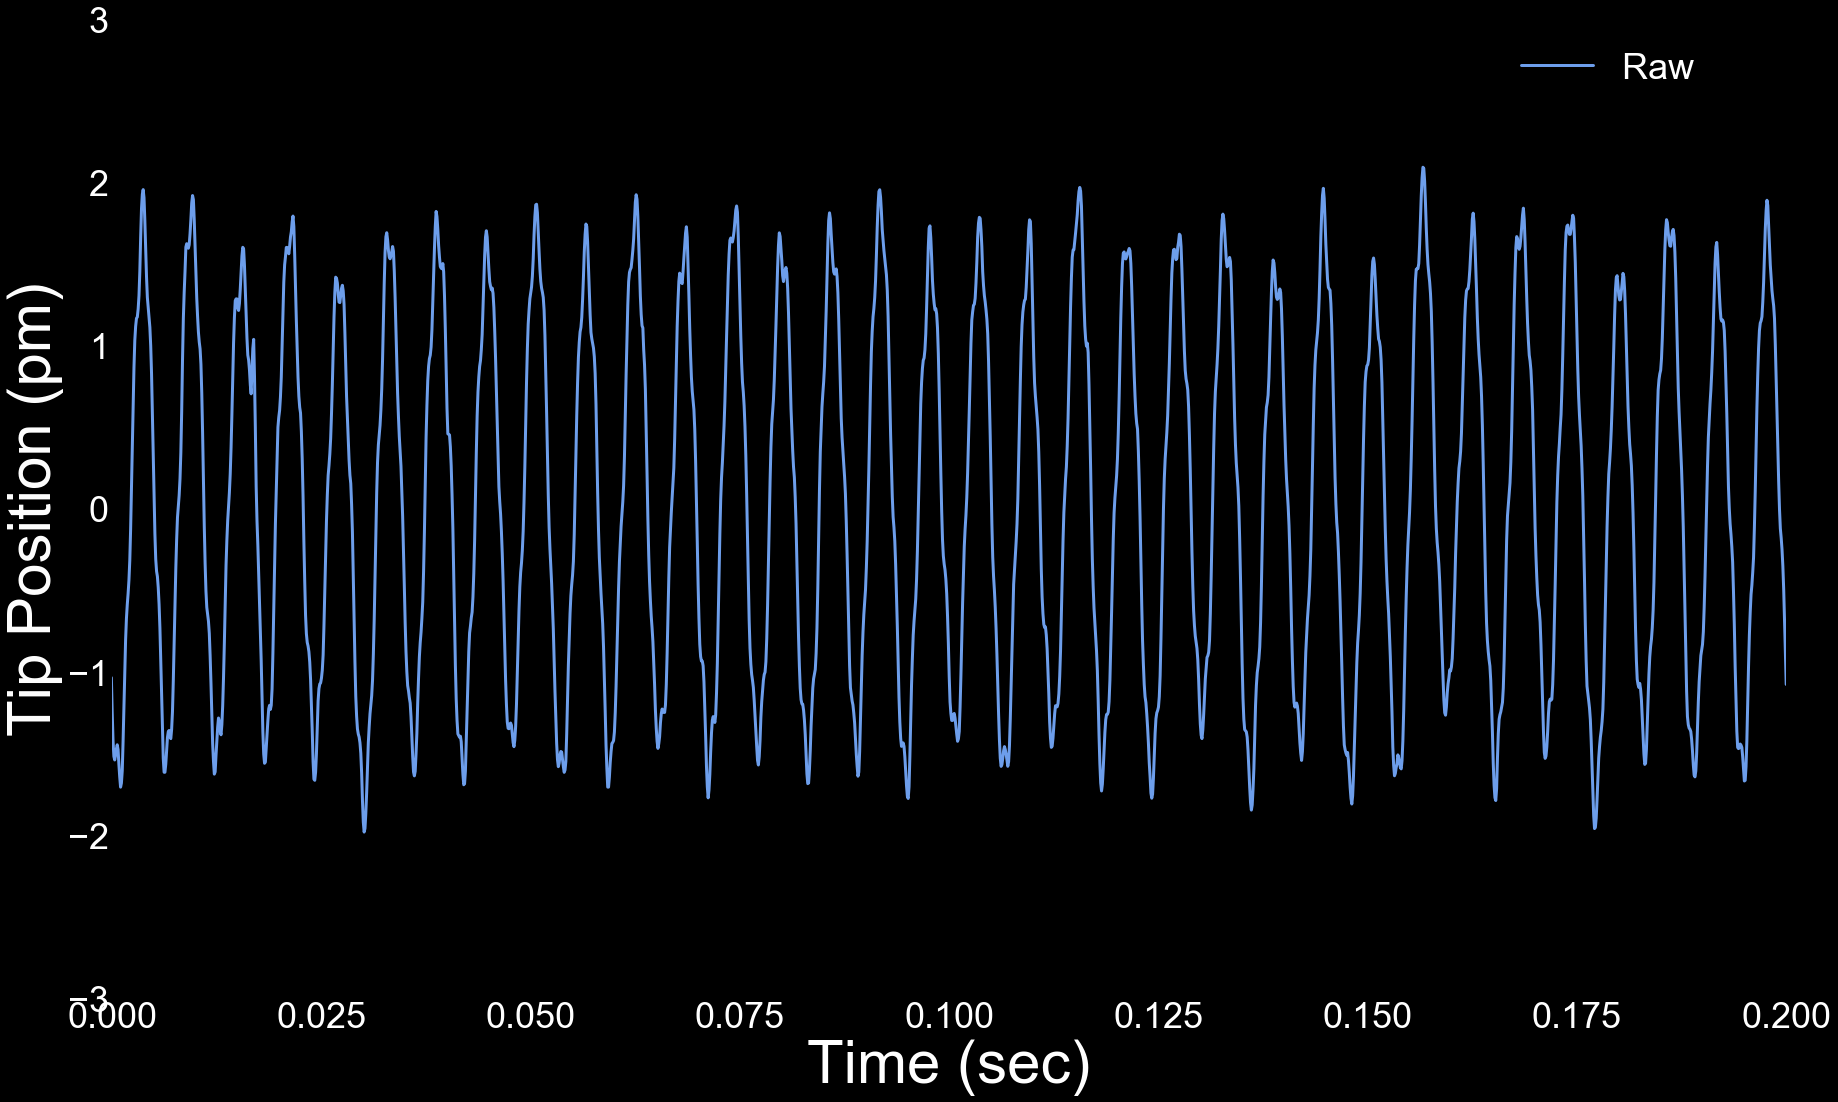

In [180]:
plt.style.use('dark_background')
figsize(30,18)
fig,ax=subplots(1,1)
delay = 0
plot(t[int(10*fs):int(100*fs-delay)]-12,1e12*tip_fit_test[int(10*fs):int(100*fs-delay)],'#6d9eeb',linewidth=3,label='Raw      ')
# plot(t[int(10*fs):int(100*fs)]-12,50*geo_test[int(10*fs):int(100*fs)],'g',label='Geophone')
# plot(t[int(10*fs):int(100*fs-delay)]-12,1e12*z_vib[delay:],'y',label='Noise')
# plot(t[int(10*fs):int(100*fs-delay)]-12,1e12*tip_fit_test[int(10*fs):int(100*fs-delay)]-1e12*z_vib[delay:],'r',linewidth=3,label='Processed')


colors ='w'
for spine in ax.spines.values():
    spine.set_edgecolor(colors)
ax.grid(False)
tick_params(labelsize=36)
xlabel('Time (sec)',size=60)
ylabel('Tip Position (pm)',size=60)
leg = legend(loc=1,fontsize = 36,fancybox=True, framealpha=0)

# for text in leg.get_texts():
#     plt.setp(text, color = colors)
xlim(0,0.2)
ylim(-3,3)
savefig('2020-3-13 Matrix Cancellation Raw',transparent=True)

In [165]:
rms_tip = sqrt(mean(tip_fit_test[int(10*fs):int(100*fs)]**2))
rms_sig = sqrt(mean((tip_fit_test[int(10*fs):int(100*fs)]-z_vib)**2))
print(100-100*abs(rms_sig/rms_tip))

72.33454142089884


In [172]:
n = 5000
raw = tip_fit_test[int(10*fs):int(100*fs)]
proc = tip_fit_test[int(10*fs):int(100*fs)]-z_vib
seg_r = np.zeros(((len(raw))//(n),n),dtype=np.complex)
seg_p = np.zeros(((len(proc))//(n),n),dtype=np.complex)
print(shape(seg_r))
r_cal_temp = np.copy(raw)
p_cal_temp = np.copy(proc)
j = 0
while len(r_cal_temp) >= n:
    seg_r[j,:] = fit_cancel(r_cal_temp[:n])
    seg_p[j,:] = fit_cancel(p_cal_temp[:n])
    j+=1
    r_cal_temp = r_cal_temp[n:]
    p_cal_temp = p_cal_temp[n:]
    
for i in range(0,len(seg_r[:,0])):
    seg_r[i,:] = np.fft.fft(seg_r[i,:])
    seg_p[i,:] = np.fft.fft(seg_p[i,:])
    
seg_r = mean(seg_r,axis=0)
seg_p = mean(seg_p,axis=0)
freqs = np.fft.fftfreq(len(seg_r),1/10000)

(180, 5000)


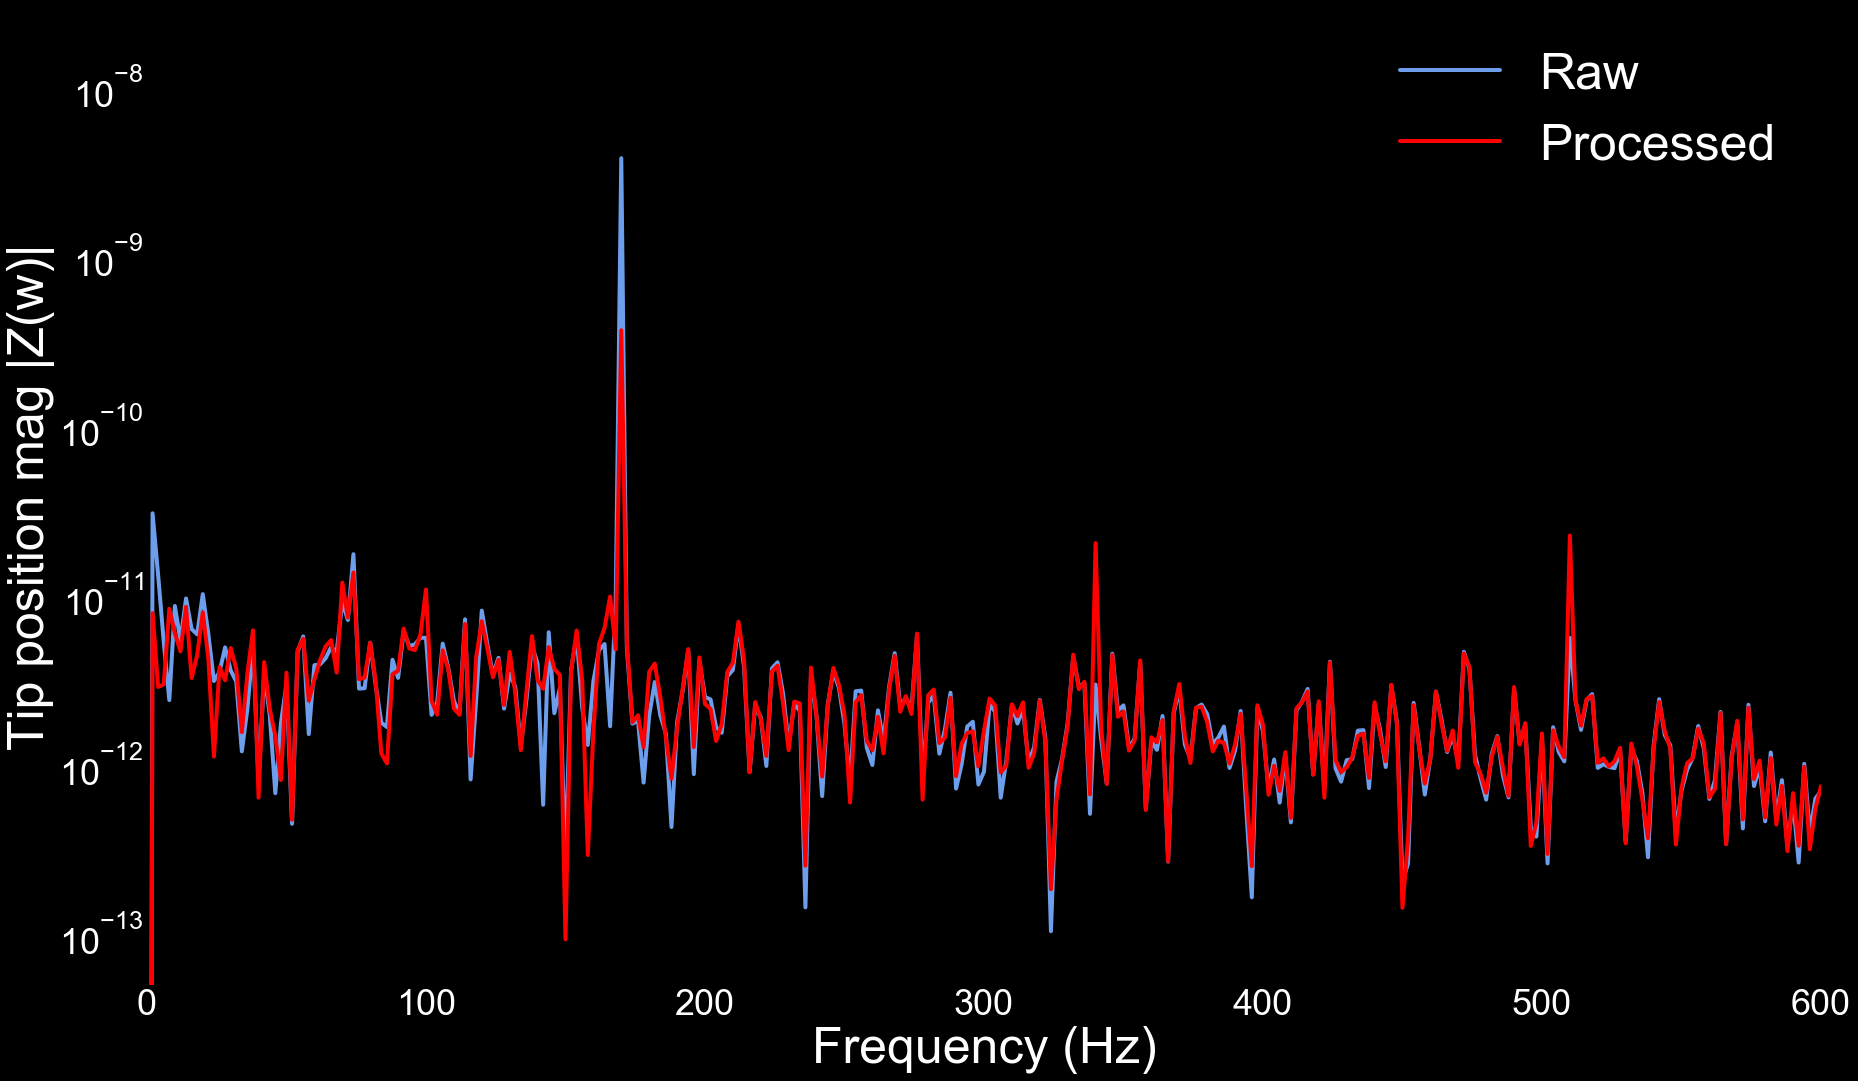

In [185]:
fig,ax=subplots(1,1)
figsize(30,18)
# fft_raw = fft.fft(tip_fit_test[int(10*fs):int(400*fs)])
# fft_processed = fft.fft(tip_fit_test[int(10*fs):int(100*fs)]-z_vib)
semilogy(freqs[:int(len(freqs)/2)],absolute(seg_r[:int(len(freqs)/2)]),'#6d9eeb',linewidth=4,label='Raw')
semilogy(freqs[:int(len(freqs)/2)],absolute(seg_p[:int(len(freqs)/2)]),'r',linewidth=4,label='Processed')
xlim(0,600)
ylim(5e-14,3e-8)
colors ='w'
for spine in ax.spines.values():
    spine.set_edgecolor(colors)
ax.grid(False)
tick_params(labelsize=36)
xlabel('Frequency (Hz)',size=50)
ylabel('Tip position mag |Z(w)|',size=50)
leg = legend(loc=1,fontsize = 50,fancybox=True, framealpha=0)

for text in leg.get_texts():
    plt.setp(text, color = colors)
    
savefig('2020-3-13 Matrix Cancellation FFT Raw-Processed',transparent=True)

In [115]:
print(freqs[85])
print((seg_r[85]))
print((seg_p[85]))
print(absolute(mean((seg_p)/(seg_r))))

170.0
(1.5998505583229687e-09+7.435785036537819e-10j)
(3.868673533418609e-11-1.7077220632776263e-10j)
0.990373243597425


In [162]:
# folder_loc = '2020-03-13/LIY Spacial 170/'
# file_loc = '2020-03-13-21-33_liy_noisy6001.dat'
# dat = np.loadtxt(folder_loc+file_loc,skiprows=76)

# for filename in os.listdir(folder_loc):
#     if filename == file_loc:
#         pass
#     try:
#         tempdata = np.loadtxt(folder_loc+filename, skiprows=76)
#         dat = np.concatenate((dat,tempdata))
#         print(filename,end='\r')
#     except:
#         print('ERROR: ',filename)

In [186]:
folder_loc = '2020-03-13/Spec Sweep Noisy 170 v2/'
file_loc = '2020-03-13-21-53_noisy170_spec001.dat'
# folder_loc = '2020-03-13/Spec Sweep Noisy 170/'
# file_loc = '2020-03-13-20-43_spec_noisy1001.dat'

dat_spec = np.loadtxt(folder_loc+file_loc,skiprows=76)

for filename in os.listdir(folder_loc):
    if filename == file_loc:
        pass
    try:
        tempdata = np.loadtxt(folder_loc+filename, skiprows=76)
        dat_spec = np.concatenate((dat_spec,tempdata))
        print(filename,end='\r')
    except:
        print('ERROR: ',filename)

In [187]:
cur = dat_spec[:,0]
geo = dat_spec[:,1]
speaker = dat_spec[:,2]
bias_mod = dat_spec[:,4]
bias = dat_spec[:,5]
Z = dat_spec[:,8]
LIY = dat_spec[:,10]

t = linspace(0,len(cur)/10000,len(cur))
print(len(cur),len(t),shape(dat_spec))

2475000 2475000 (2475000, 11)


324


(0, 25)

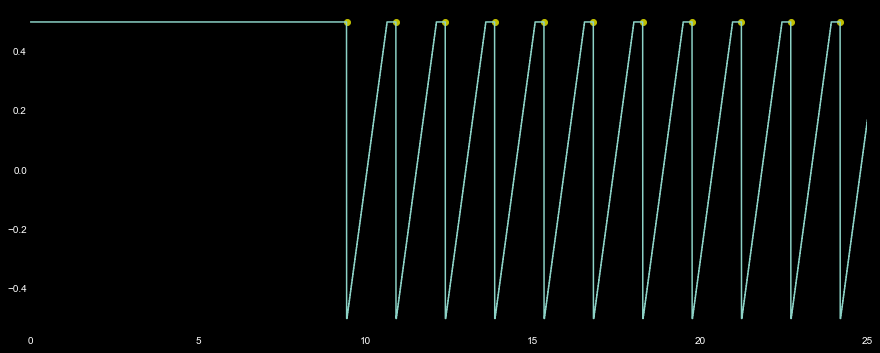

In [188]:
figsize(15,6)
dt = t[1]
grad = np.gradient(bias,dt)
brk_pnt = np.argsort(grad)[:600]
count = 0
for j in brk_pnt:
    if grad[j] < -1000:
        count = count+1
print(count)

brk_pnt = np.argsort(grad)[:count]
brk_pnt = np.sort(brk_pnt)
# print(brk_pnt)
for idx,point in enumerate(brk_pnt):
    temp_pnt = point
    brk_pnt[np.where(absolute(brk_pnt-point)<10)] = 0
    brk_pnt[idx] = point
brk_pnt = np.sort(brk_pnt[brk_pnt != 0])
# brk_pnt = np.append(brk_pnt,-1)
# print(brk_pnt)

plot(t[brk_pnt],bias[brk_pnt],'yo')
plot(t,bias)
grid(False)
# plot(t,grad)
start = 0
xlim(start,start+25)
# ylim(-5009,-4900)

In [189]:
start = brk_pnt[0]+1
end = brk_pnt[-1]

cur_cut = dat_spec[:start,0]
geo_cut = dat_spec[:start,1]
speaker_cut = dat_spec[:start,2]
bias_mod_cut = dat_spec[:start,4]
bias_cut = dat_spec[:start,5]
Z_cut = dat_spec[:start,8]
LIY_cut = dat_spec[:start,10]

t = linspace(0,len(cur_cut)/10000,len(cur_cut))
print(len(cur_cut),len(t))

94405 94405


In [641]:
folder_loc = '2020-03-13/Noisy Calibration Lockin 170/'
file_loc = '2020-03-13-21-40_noisy170_lockin_cal001.dat'
dat = np.loadtxt(folder_loc+file_loc,skiprows=76)

for filename in os.listdir(folder_loc):
    if filename == file_loc:
        pass
    try:
        tempdata = np.loadtxt(folder_loc+filename, skiprows=76)
        dat = np.concatenate((dat,tempdata))
        print(filename,end='\r')
    except:
        print('ERROR: ',filename)

In [642]:
cur_cal = dat[:,0]
Z_cal = dat[:,8]

In [643]:
n = 10000
seg_C = np.zeros(((len(cur_cal))//(n),n),dtype=np.complex)
seg_Z = np.zeros(((len(Z_cal))//(n),n),dtype=np.complex)
print(shape(seg_C))
C_cal_temp = np.copy(cur_cal)
Z_cal_temp = np.copy(Z_cal)
j = 0
while len(C_cal_temp) >= n:
    seg_C[j,:] = fit_cancel(C_cal_temp[:n])
    seg_Z[j,:] = fit_cancel(Z_cal_temp[:n])
    j+=1
    C_cal_temp = C_cal_temp[n:]
    Z_cal_temp = Z_cal_temp[n:]
    
for i in range(0,len(seg_C[:,0])):
    seg_C[i,:] = np.fft.fft(seg_C[i,:])
    seg_Z[i,:] = np.fft.fft(seg_Z[i,:])
    
seg_C = mean(seg_C,axis=0)
seg_Z = mean(seg_Z,axis=0)
freqs = np.fft.fftfreq(len(segs),1/10000)

(777, 10000)


[ 2.69440206+14.21584393j  1.94197259+15.2653525j
  2.03549409+17.33135621j  1.26555931+16.19231664j
  0.17679584+18.34623567j 12.72379389+54.01245233j
  1.43601436+16.34702197j  0.58485218+18.19135769j
  3.95907055 +9.76916665j  2.89739321+27.78133293j]
[14.21584393 15.2653525  17.33135621 16.19231664 18.34623567 54.01245233
 16.34702197 18.19135769  9.76916665 27.78133293]


(0, 3000)

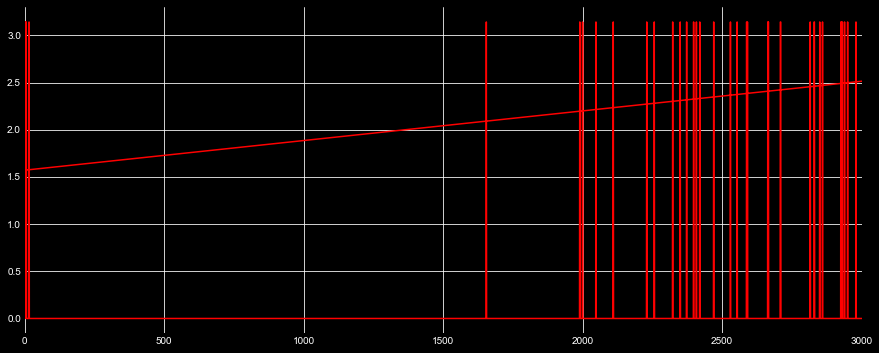

In [644]:
T_theta  = (imag(seg_C/seg_Z))

print(seg_C[100:110]/seg_Z[100:110])
print(T_theta[100:110])
plot(freqs,angle(T_theta),'r')
xlim(0,3000)
# ylim(-10,100)

In [645]:
T_theta = scipy.interpolate.interp1d(freqs,T_theta,kind='linear',fill_value='extrapolate')

In [646]:
# T_theta = angle(fft.fft(cur_cut)/fft.fft(Z_cut))

# print(len(T_theta))
# plot(T_theta)

In [193]:
G = fft.fft(geo_cut[10:]-mean(geo_cut[10:]))
omega = fft.fftfreq(len(geo_cut[10:]),1/10000)
G = scipy.interpolate.interp1d(omega,G,kind='linear',fill_value='extrapolate')

In [194]:
z_omega = (C1(omega)*G(omega) + 0.1*C2(omega/2)*G(omega/2) + 0.1*C3(omega/3)*G(omega/3) +
           0.1*C4(omega/4)*G(omega/4))
z_vib = fft.ifft(z_omega)

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


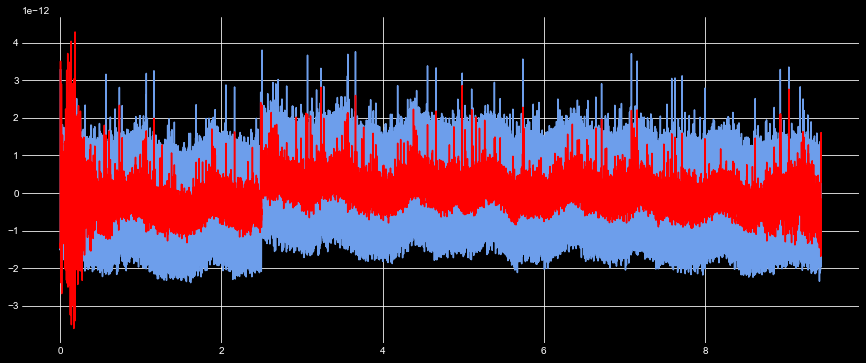

In [195]:
plot(t[10:],fit_cancel(Z_cut[10:]),'#6d9eeb',label='Raw')
# plot(t[10:],z_vib,'g',label="noise")
plot(t[10:],fit_cancel(Z_cut[10:])-z_vib,'r',label='Processed')
# xlim(3,3.1)

(1e-12, 0.0001)

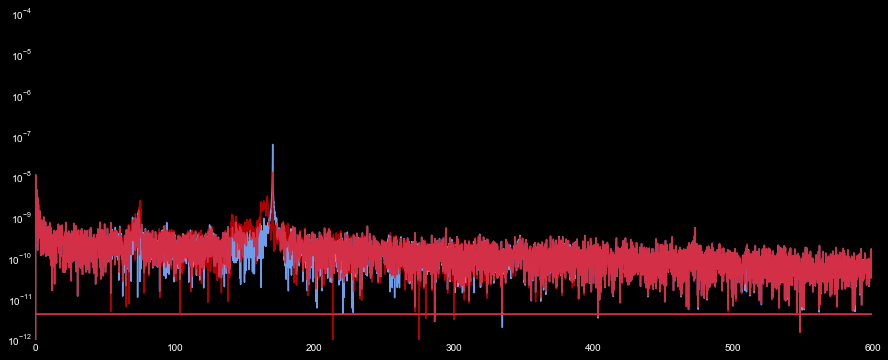

In [196]:
z_fft = fft.fft(fit_cancel(Z_cut[10:]))
z_sig_fft = fft.fft(fit_cancel(Z_cut[10:])-z_vib)
freqs = fft.fftfreq(len(Z_cut[10:]),1/10000)
semilogy(freqs,absolute(z_fft),'#6d9eeb')
semilogy(freqs,absolute(z_sig_fft),'r',alpha=0.7)
# z_omega_shift = (z_omega.real+1j*(z_omega*T_theta(omega)).imag)
# semilogy(omega,absolute(z_omega),'#6d9eeb')
# semilogy(omega,absolute(z_omega_shift),'r',alpha=0.7)
grid(False)
xlim(0,600)
ylim(1e-12,1e-4)

In [197]:
C[int(len(C[:,0])/2):,:] = flip(conj(C[1:int(len(C[:,0])/2)+2]),axis=0)
z_omega_shift = (z_omega.real+1j*(z_omega*T_theta(omega)).imag)
z_shift_vib = fft.ifft(z_omega_shift)
# z_omega_shift[int(len(z_omega_shift)/2):] = flip(conj(z_omega_shift[1:int(len(z_omega_shift)/2)+2]))   
print('Unshiftted:',z_omega[2000])
print('Shifted:',z_omega[2000].real+1j*(z_omega*T_theta(omega))[2000].imag)
# print(z_omega[-2000])
# print(z_omega[-2000].real+1j*(z_omega*T_theta(omega))[-2000].imag)
# print(z_shift_vib[1000])
print('Shift amount:',T_theta(omega)[-2000])
# plot(t[10:],z_vib*1.55555e1,'#6d9eeb')
# plot(t[10:],z_shift_vib*1.55555e1,'r')
delay =12
plot(t[10:-delay],fit_cancel(cur_cut[10:-delay]))

plot(t[10:-delay],z_vib[delay:]*1.55555e1,'y')
# plot(t[10:],fit_cancel(exp(1.55555e1*(fit_cancel(Z_cut[10:])))),'y')
xlim(2,2.05)

NameError: name 'T_theta' is not defined

In [198]:
folder_loc = '2020-03-13/'
file_loc = 'kappa00006.dat'
dat = np.loadtxt(folder_loc+file_loc,skiprows=126)
z_kap = dat[:,0]
cur_kap = dat[:,1]

-3.2738004358080005e-11


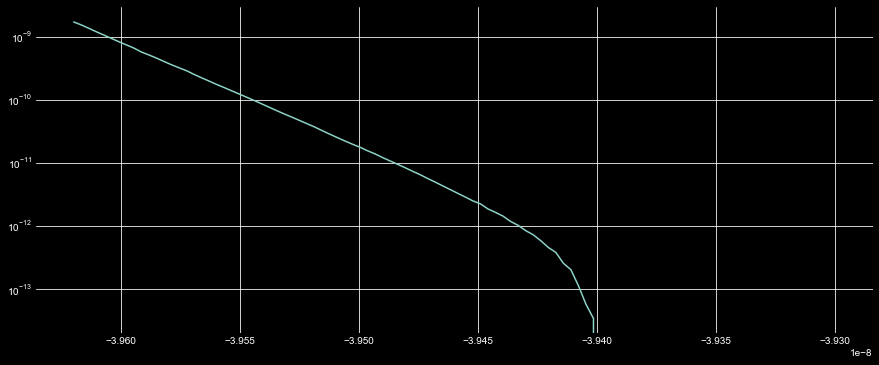

In [199]:
x=linspace(0,len(cur_kap),len(cur_kap))
fit = polyfit(x,(cur_kap),2)
# polyfitted = poly1d(polyfit(z_kap,cur_cap-mean(tip[::600]),15))
print(fit[1])
semilogy(z_kap,cur_kap)

# semilogy(z_kap,-)

In [200]:
kappa=-3.273855e10
delay = 12
cur_vib = exp(-kappa*(z_vib[delay:]))
rms_cur = sqrt(mean(cur_cut[10:-delay]**2))
kappa_test = linspace(-2.4e10,-2.6e10,5000)
base = 1.0012974925984475e-09
print(base)
for k in kappa_test:
    print(k,end='\r')
    cur_vib_test = exp(-k*(z_vib[delay:]-mean(z_vib[delay:])))
    sig = cur_cut[10:-delay]/cur_vib_test
    rms_sig = sqrt(mean(sig**2))
    if rms_sig < base:
        base = rms_sig
        kappa_final = k
print(base)
print(kappa_final)


1.0012974925984475e-09
(1.0004730422475414e-09+6.781642151524274e-30j)
-24929385877.175434


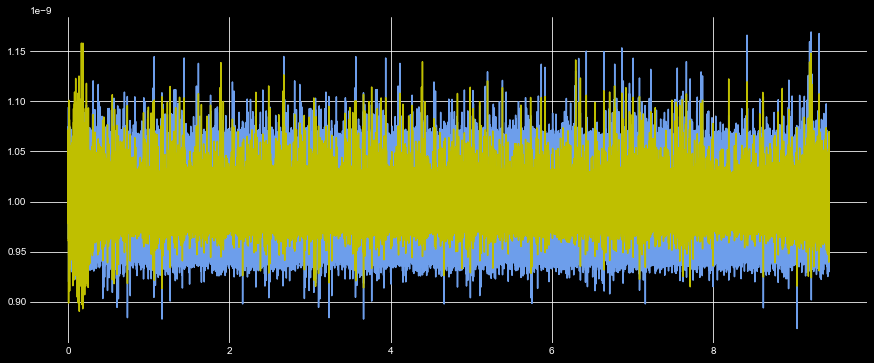

In [201]:
cur_vib = exp(-kappa_final*(z_vib[delay:]))
plot(t[10:-delay],cur_cut[10:-delay],'#6d9eeb')
plot(t[10:-delay],cur_cut[10:-delay]/cur_vib,'y')
# plot(t[10:-delay],cur_vib,'g')
# xlim(2,2.05)

94405


(1e-11, 1e-05)

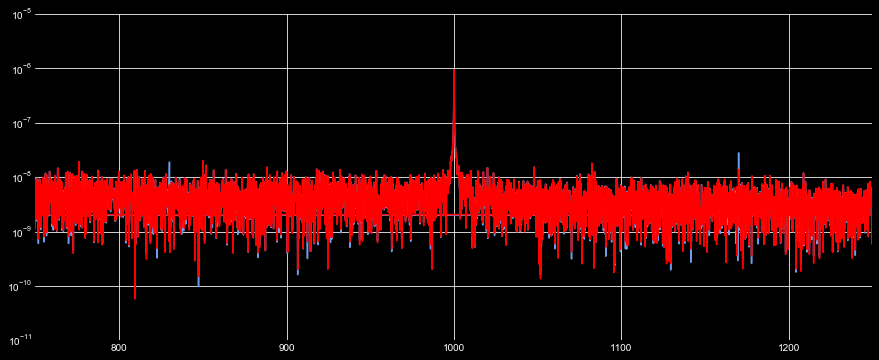

In [202]:
print(len(cur_cut))
cur_fft= fft.fft(cur_cut[10:-delay])
cur_sig_fft = fft.fft(cur_cut[10:-delay]/cur_vib)
cur_vib_fft = fft.fft(cur_vib)
freqs=fft.fftfreq(len(cur_fft),1/10000)
semilogy(freqs,absolute(cur_fft),'#6d9eeb')
semilogy(freqs,absolute(cur_sig_fft),'r')
# semilogy(freqs,absolute(cur_vib_fft),'g',alpha=0.5)
xlim(750,1250)
ylim(1e-11,1e-5)

In [203]:
start = brk_pnt[0]+3
end = brk_pnt[-1]+2

cur_cut = dat_spec[start:end,0]
geo_cut = dat_spec[start:end,1]
speaker_cut = dat_spec[start:end,2]
bias_mod_cut = dat_spec[start:end,4]
bias_cut = dat_spec[start:end,5]
Z_cut = dat_spec[start:end,8]
LIY_cut = dat_spec[start:end,10]

t = linspace(0,len(cur_cut)/10000,len(cur_cut))
print(len(cur_cut),len(t))

2373622 2373622


In [206]:
def coef(w,geo,tip,t_array,harmonic,fs=1000):
    
    if w*harmonic >= fs/2:
        return 0 + 0*1j
    
    ref_tip = tip*(np.cos(w*harmonic*2*pi*t_array)-1j*sin(w*harmonic*2*pi*t_array)) 
    ref_geo = geo*(np.cos(w*2*pi*t_array)-1j*sin(w*2*pi*t_array))
    
    sos = signal.butter(10, w/5, 'lowpass', fs=fs, output='sos')
    
    filt_tip = signal.sosfiltfilt(sos,ref_tip)
    filt_geo = signal.sosfiltfilt(sos,ref_geo)
    
    
    lock_tip = average(filt_tip)
    lock_geo = average(filt_geo)
    Z = lock_tip/lock_geo
    
    return Z

prev = 0
harmonics = 10
steps = 10000
loc = linspace(60272,len(t),int(steps/30 -1)).astype('int')
# loc = (change_loc*fs).astype('int')
freq_map = linspace(50,400,len(loc))
fftfreq = fft.fftfreq(int(10000/(freq_map[1]-50)),1/10000)
# print(np.where(absolute(fftfreq-400) <0.1))

C = np.zeros((len(fftfreq),harmonics),dtype='complex128')

for w,point,i in zip(freq_map,loc,arange(len(freq_map))):
    i = i+48
    print(w,end='\r')
    input_wave = geo[prev:point]
    output_wave = cur[prev:point]
    t_split = t[prev:point]
    for j in arange(harmonics):
        C[i,j] = coef(w,input_wave,output_wave,t_split,(j+1),fs = 10000)
        
    prev = point
    
C[int(len(C[:,0])/2):,:] = flip(conj(C[1:int(len(C[:,0])/2)+2]),axis=0)

In [207]:
C1 = scipy.interpolate.interp1d(fftfreq,C[:,0], kind='linear',fill_value='extrapolate')
C2 = scipy.interpolate.interp1d(fftfreq,C[:,1], kind='linear',fill_value='extrapolate')
C3 = scipy.interpolate.interp1d(fftfreq,C[:,2], kind='linear',fill_value='extrapolate')
C4 = scipy.interpolate.interp1d(fftfreq,C[:,3], kind='linear',fill_value='extrapolate')
C5 = scipy.interpolate.interp1d(fftfreq,C[:,4], kind='linear',fill_value='extrapolate')
C6 = scipy.interpolate.interp1d(fftfreq,C[:,5], kind='linear',fill_value='extrapolate')

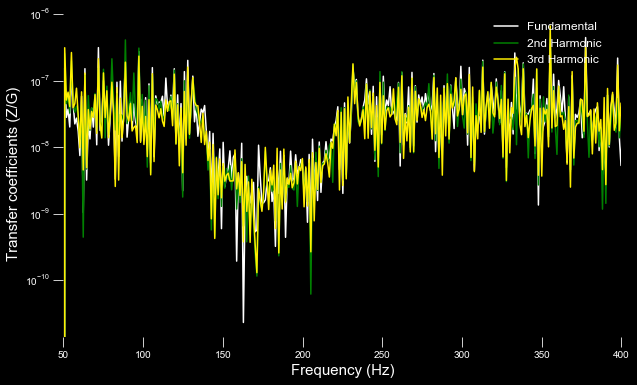

In [208]:
figsize(10,6)

# print(freq_map[1]-50)
# print(fftfreq[379])

fig,ax=subplots(1,1)

semilogy(fftfreq,absolute(C[:,0]),'w',label='Fundamental    ')
semilogy(fftfreq,absolute(C[:,1]),'g',label='2nd Harmonic')
semilogy(fftfreq,absolute(C[:,2]),'#ffef00',label='3rd Harmonic')
xlim(50,400)
tick_params(size= 10)
grid(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')
xlabel('Frequency (Hz)',size=15)
ylabel('Transfer coefficients (Z/G)',size = 15)
legend(loc=1,fontsize=12)
savefig('2020-3-13 Matrix G-I coefficients')

322 322


(-5, 100)

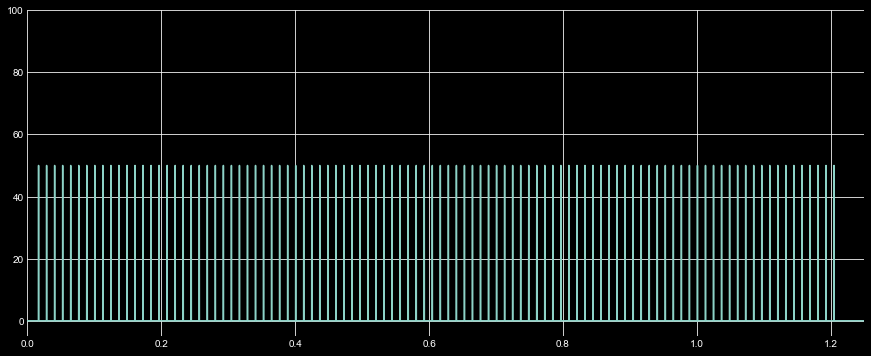

In [209]:
figsize(15,6)
dt = t[1]
grad = np.gradient(bias_cut,dt)
swp_pnt = np.argsort(grad)[:322]
count = 0
for j in swp_pnt:
    if grad[j] < -1000:
        count = count+1
print(count,len(swp_pnt))
swp_pnt = (np.sort(swp_pnt))
swp_pnt = swp_pnt[:322]
plot(t[swp_pnt],grad[swp_pnt],'r.')
# plot(t,bias_cut)
plot(t,grad)
start = 0
xlim(start,start+1.25)
ylim(-5,100)

200
[  168   288   408   528   648   768   888  1008  1128  1248  1368  1488
  1608  1728  1848  1968  2088  2208  2328  2448  2568  2688  2808  2928
  3048  3168  3288  3408  3528  3648  3768  3888  4008  4128  4248  4368
  4488  4608  4728  4848  4968  5088  5208  5328  5448  5568  5688  5808
  5928  6048  6168  6288  6408  6528  6648  6768  6888  7008  7128  7248
  7368  7488  7608  7728  7848  7968  8088  8208  8328  8448  8568  8688
  8808  8928  9048  9168  9288  9408  9528  9648  9768  9888 10008 10128
 10248 10368 10488 10608 10728 10848 10968 11088 11208 11328 11448 11568
 11688 11808 11928 12048 14739]


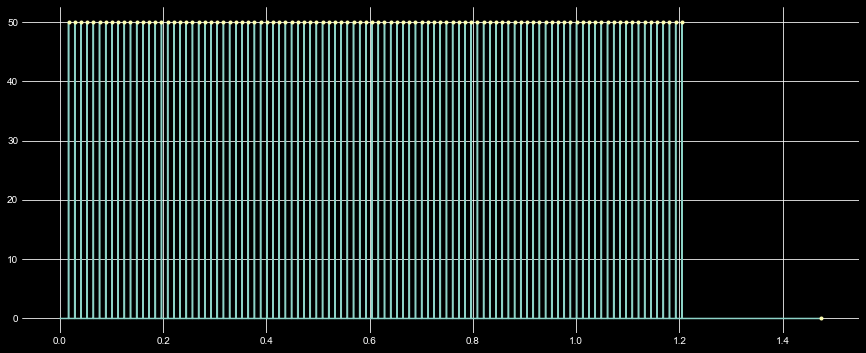

In [210]:
prev = 0
for brk in swp_pnt:
    grad_brk = grad[prev:brk]
    brk_pnt_2 = np.flip(np.argsort(grad_brk))[:200]
    brk_pnt_2 = (np.sort(brk_pnt_2))
    
    count = 0
    for j in brk_pnt_2:
        if grad_brk[j] > 20:
            count = count+1
    print(count)
#     plot(t[prev:brk],grad_brk)
#     plot(t[brk_pnt_2],grad_brk[brk_pnt_2],'.')
#     xlim(0,0.2)
    break

step_pnt = np.flip(np.argsort(grad_brk))[:200]
step_pnt = -np.sort(-step_pnt)
# print(brk_pnt)
for idx,point in enumerate(step_pnt):
    temp_pnt = point
    step_pnt[np.where(absolute(step_pnt-point)<10)] = 0
    step_pnt[idx] = point
step_pnt = np.sort(step_pnt[step_pnt != 0])
step_pnt = np.append(step_pnt,len(grad_brk)-1)
plot(t[prev:brk],grad_brk)
plot(t[step_pnt],grad_brk[step_pnt],'.')
print(step_pnt)

In [212]:
prev = 0 

I_n = np.zeros(len(step_pnt))
reps = np.zeros(len(step_pnt))
for idx,point in enumerate(step_pnt):
    I_n[idx] = mean(cur_cut[prev:point])
    reps[idx] = point-prev
    prev = point
reps[-1] = reps[-1] +1
# print(len(I_n),reps.astype('int'))
# print(I_n)
I_n = repeat(I_n,reps.astype('int'))

print(len(cur_cut[:brk]),len(I_n),I_n[0])

14740 14740 -9.164837949404763e-10


(0, 1.2)

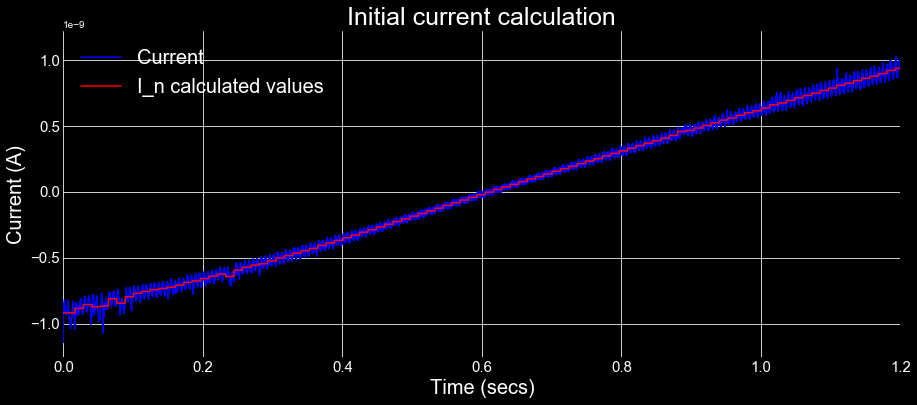

In [213]:
plot(t[:brk],cur_cut[:brk],'b',label='Current')
plot(t[:brk],I_n,'r',label='I_n calculated values')
# color= 'w'
tick_params(labelsize=15)
title('Initial current calculation',size=25)
xlabel('Time (secs)',size=20)
ylabel('Current (A)',size=20)
leg = legend(loc=2, fontsize = 20,fancybox=True, framealpha=0)
xlim(0,1.2)

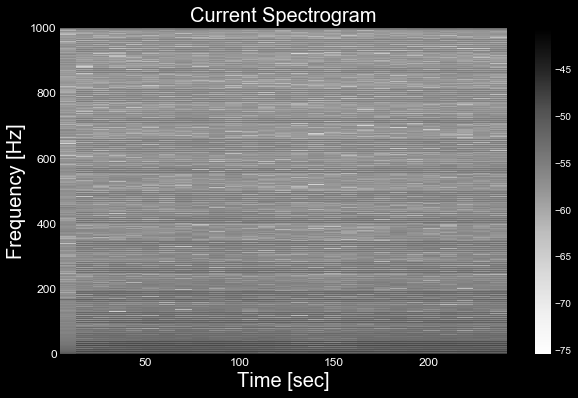

In [214]:
fig,ax =subplots(1,1,figsize=(10,6))
fs = 10000
f, t_spt, Sxx = signal.spectrogram(cur, fs,nperseg=100000)
# _,__,Sxx_2 = signal.spectrogram(geo,fs,nperseg=100000)
# plot(Sxx[:,100])
im1 = ax.pcolormesh(t_spt,f,log(Sxx))#,vmin=-60,vmax=-50)#,vmin=1e-36,vmax = 1e-18)
colors= 'w'
tick_params(labelsize=12,colors=colors)
ax.set_title('Current Spectrogram',size=20,color=colors)
ax.set_ylabel('Frequency [Hz]',size=20,color=colors)
ax.set_xlabel('Time [sec]',size=20,color=colors)
ax.set_ylim(0,1000)
# xlim(395,420)
fig.colorbar(im1)

# savefig('2020-03-13 Current log Spectrogram (ON)',transparent=True)

In [215]:
print(len(cur))

2475000


In [216]:
G_sweep = fft.fft(geo_cut)
omega = fft.fftfreq(len(geo_cut),1/10000)
G_sweep = scipy.interpolate.interp1d(omega,G_sweep,kind='linear',fill_value='extrapolate')

In [217]:
cur_swp_omega = C1(omega)*G_sweep(omega) + C2(omega/2)*G_sweep(omega/2)+ C3(omega/3)*G_sweep(omega/3) + C4(omega/4)*G_sweep(omega/4)  
cur_swp_vib = fft.ifft(cur_swp_omega)

In [222]:
cur_sig_brk = cur_cut[:brk]-I_n*cur_swp_vib[:brk]

(0, 500)

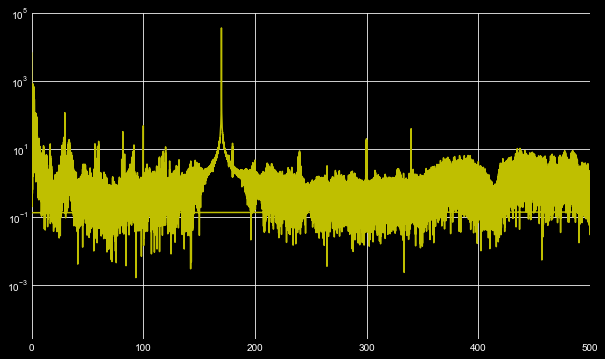

In [220]:
semilogy(omega,absolute(G_sweep(omega)),'y')
# semilogy(omega,absolute(z_swp_omega),'r')
# plot(fft.fftfreq(len(cur_)))
xlim(0,500)

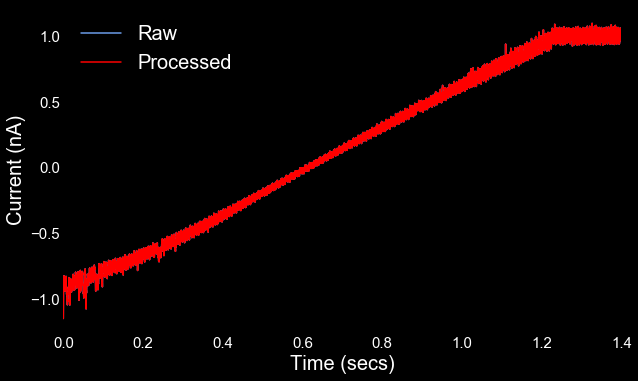

In [224]:
delay=0
figsize(10,6)
# cur_swp_vib = exp(-kappa_final*(z_swp_vib))
plot(t[:brk-delay],1e9*cur_cut[:brk-delay],'#6d9eeb',label='Raw')
plot(t[:brk-delay],1e9*cur_sig_brk,'r',label='Processed')
grid(False)
tick_params(labelsize=15)
# title('Initial current calculation',size=25)
xlabel('Time (secs)',size=20)
ylabel('Current (nA)',size=20)
leg = legend(loc=2, fontsize = 20,fancybox=True, framealpha=0)
xlim(0,1.4)
# ylim(-0.1e-9,0.2e-9)
savefig('2020-03-13 voltage sweep matrix cancellation',transparent=True)

In [696]:
# # plot(cur)
# def fit_cancel(array, n=1):
#     t=linspace(0,len(array),len(array))
#     fit = polyfit(t,array,n)
#     corrective = fit[n]*ones(shape(t))
#     for j in arange(n):
#         corrective += fit[j]*(t**(n-j))
#     return array - corrective

# start = int(19.1*fs)
# end = int(369.1*fs)
# # print(end)
# # current_clip = current[start:end+start+1]
# chirp_clip = chirp[start:end]
# geo_clip = geo[start:end]
# tip_clip = fit_cancel(Z)[start:end]
# print(len(chirp_clip),len(geo_clip),len(tip_clip))

In [697]:
# seperation = 0.1
# change_loc = linspace(0.1,350.1,350000)
# loc = (change_loc*fs).astype('int')
# freq_map = linspace(50,400,len(loc))
# fftfreq = fft.fftfreq(int(10000/(freq_map[1]-50)),1/10000)
# print(np.where(absolute(fftfreq-50) <0.01))

In [698]:
# def coef(w,geo,tip,t_array,harmonic,fs=1000):
    
#     if w*harmonic >= fs/2:
#         return 0 + 0*1j
    
#     ref_tip = tip*(np.cos(w*harmonic*2*pi*t_array)-1j*sin(w*harmonic*2*pi*t_array)) 
#     ref_geo = geo*(np.cos(w*2*pi*t_array)-1j*sin(w*2*pi*t_array))
    
#     sos = signal.butter(10, w/5, 'lowpass', fs=fs, output='sos')
    
#     filt_tip = signal.sosfilt(sos,ref_tip)
#     filt_geo = signal.sosfilt(sos,ref_geo)
    
    
#     lock_tip = average(filt_tip)
#     lock_geo = average(filt_geo)
#     Z = lock_tip/lock_geo
    
#     return Z

# prev = 0
# harmonics = 10
# seperation = 0.1
# change_loc = linspace(0.1,350.1,350000)
# loc = (change_loc*fs).astype('int')
# freq_map = linspace(50,400,len(loc))
# fftfreq = fft.fftfreq(int(10000/(freq_map[1]-50)),1/10000)
# # print(fftfreq[387])
# # print(fftfreq[64])
# # print(len(fftfreq))
# C = np.zeros((len(fftfreq),harmonics),dtype='complex128')


# for w,point,i in zip(freq_map,loc,arange(len(freq_map))):
#     i = i+50000
#     print(w,end='\r')
#     input_wave = geo_clip[prev:point]
#     output_wave = tip_clip[prev:point]
#     t_split = t[prev:point]
#     for j in arange(harmonics):
#         C[i,j] = coef(w,input_wave,output_wave,t_split,(j+1),fs = 20000)

#     prev = point
# C[int(len(C[:,0])/2):,:] = flip(conj(C[1:int(len(C[:,0])/2)+1]),axis=0)

In [699]:
# plot(fftfreq,absolute(C[:,0]))
# # semilogy(fftfreq,absolute(C[:,1]))
# # semilogy(fftfreq,absolute(C[:,2]))
# # semilogy(fftfreq,absolute(C[:,3]))
# tick_params(labelsize=12,colors='white')
# xlabel('Frequency (Hz)',size=20,color='white')
# ylabel('Amplitude',size=20,color='white')
# xlim(50,300)

In [700]:
# C1 = scipy.interpolate.interp1d(fftfreq,C[:,0], kind='linear',fill_value='extrapolate')
# C2 = scipy.interpolate.interp1d(fftfreq,C[:,1], kind='linear',fill_value='extrapolate')
# C3 = scipy.interpolate.interp1d(fftfreq,C[:,2], kind='linear',fill_value='extrapolate')
# C4 = scipy.interpolate.interp1d(fftfreq,C[:,3], kind='linear',fill_value='extrapolate')
# C5 = scipy.interpolate.interp1d(fftfreq,C[:,4], kind='linear',fill_value='extrapolate')
# C6 = scipy.interpolate.interp1d(fftfreq,C[:,5], kind='linear',fill_value='extrapolate')
# C7 = scipy.interpolate.interp1d(fftfreq,C[:,6], kind='linear',fill_value='extrapolate')
# C8 = scipy.interpolate.interp1d(fftfreq,C[:,7], kind='linear',fill_value='extrapolate')
# C9 = scipy.interpolate.interp1d(fftfreq,C[:,8], kind='linear',fill_value='extrapolate')
# C10 = scipy.interpolate.interp1d(fftfreq,C[:,9], kind='linear',fill_value='extrapolate')
# C11 = scipy.interpolate.interp1d(fftfreq,C[:,10], kind='linear',fill_value='extrapolate')
# C12 = scipy.interpolate.interp1d(fftfreq,C[:,11], kind='linear',fill_value='extrapolate')
# C13 = scipy.interpolate.interp1d(fftfreq,C[:,12], kind='linear',fill_value='extrapolate')
# C14 = scipy.interpolate.interp1d(fftfreq,C[:,13], kind='linear',fill_value='extrapolate')
# C15 = scipy.interpolate.interp1d(fftfreq,C[:,14], kind='linear',fill_value='extrapolate')
# C16 = scipy.interpolate.interp1d(fftfreq,C[:,15], kind='linear',fill_value='extrapolate')
# C17 = scipy.interpolate.interp1d(fftfreq,C[:,16], kind='linear',fill_value='extrapolate')
# C18 = scipy.interpolate.interp1d(fftfreq,C[:,17], kind='linear',fill_value='extrapolate')
# C19 = scipy.interpolate.interp1d(fftfreq,C[:,18], kind='linear',fill_value='extrapolate')
# C20 = scipy.interpolate.interp1d(fftfreq,C[:,19], kind='linear',fill_value='extrapolate')

In [701]:
# G = fft.fft(geo[:int(5*fs)])
# omega = fft.fftfreq(len(geo[:int(5*fs)]),1/20000)
# G = scipy.interpolate.interp1d(omega,G,kind='linear',fill_value='extrapolate')

In [702]:
# z_omega = (C1(omega)*G(omega))# + C2(omega/2)*G(omega/2) + C3(omega/3)*G(omega/3) +
# #            C4(omega/4)*G(omega/4))
# z_vib = fft.ifft(z_omega)

In [703]:
# plot(t[:int(5*fs)],poly_z[:int(5*fs)]-z_vib)
# plot(t[:int(5*fs)],poly_z[:int(5*fs)])
# tick_params(labelsize=12,colors='white')
# xlabel('Frequency (Hz)',size=20,color='white')
# ylabel('Amplitude',size=20,color='white')

In [695]:
# chirp_chunk = chirp[:500000]
# # t = t[80000:300000]-8
# # chirp_chunk2 = chirp[35000000:]
# t = t[:500000]
# print(shape(t))
# print(shape(chirp_chunk))

In [694]:
# figsize(15,6)
# freq = 2*pi*50
# freq2 = 2*pi*50.02
# wave1 = cos(freq*t) + 1j*sin(freq*t)
# wave2 = cos(freq2*t) + 1j*sin(freq2*t)
# gradient_chirp = gradient(chirp_chunk,t[1])
# sos = signal.butter(8,100/10000, 'low',output='sos')
# print(len(chirp_chunk),len(wave1))
# output1 = signal.sosfiltfilt(sos, chirp_chunk)
# output2 = signal.sosfiltfilt(sos, chirp_chunk*wave2)
# grad_output1 = gradient(output1,t[1])
# grad_output2 = gradient(output2,t[1])


# plot(t,chirp_chunk-mean(chirp_chunk))
# plot(t,0.149*sin(50*2*pi*t+0.17*pi))
# plot(t,chirp_chunk-mean(chirp_chunk)-0.15*sin(50*2*pi*t+0.18*pi))
# plot(t,chirp_chunk*wave1)
# plot(t,grad_output1)
# plot(t,gradient_chirp)

# window = 1000
# val = zeros(len(grad_output),dtype=type(grad_output[1]))
# for idx,j in enumerate(grad_output[window:]):
#     idx = (idx+window)
#     val[int(idx)] = mean(grad_output[int(idx-window):idx])
#     print(idx,end='\r')

# xlim(30.6,30.7)

# ylim(-0.16,0.16)

In [693]:
# phase = 0.20754*pi
# phase2 = 0.73353*pi
# wave = sin(50*2*pi*t + phase)
# wave2 = sin(400*2*pi*t + phase2)
# wave2 = cos(400*2*pi*t) + 1j*sin(400*2*pi*t)
# freq = 400*2*pi
# wave1 = cos(freq*t) + 1j*sin(freq*t)
# sos = signal.butter(8,100/10000, 'low',output='sos')
# output2 = signal.sosfiltfilt(sos, chirp_chunk2)
# grad = gradient(output2,t[1])
# plot(t,chirp_chunk2)
# plot(t,chirp_chunk2*wave2)
# plot(t,grad)
# plot(t,chirp_chunk-mean(chirp_chunk)-0.15*wave)
# plot(t,output1-mean(output1)-0.075*wave)
# plot(t,chirp_chunk2-mean(chirp_chunk2))
# plot(t,0.15*wave2)
# plot(t,chirp_chunk2-mean(chirp_chunk2)-0.15*wave2)
# plot(t[112000],0*chirp_chunk[111100],'o')
# plot(t,output1)
# plot(t,(grad_output1))
# plot(t,val+0.007)
# print(grad_output1[5000:])
# plot(t,angle(grad_output2))
# plot(t[289100],0*chirp_chunk2[113050],'o')
# plot(t,0.15*sin(50*2*pi*t+phase))
# plot(t,chirp_chunk-0.15*sin(50*2*pi*t+phase))
# plot(t,chirp_chunk-0.15*sin(50.01*2*pi*t+phase2))
# plot(t,chirp_chunk*wave)
# plot(t,1e2*grad_output)
# xlim(700,720)
# ylim(-0.2,0.2)

In [691]:
# fig,ax =subplots(1,1,figsize=(10,6))
# fs = 10000
# f, t, Sxx = signal.spectrogram(cur, fs,nperseg=1000)
# _,__,Sxx_2 = signal.spectrogram(geo,fs,nperseg=100000)
# # plot(Sxx[:,100])
# im1 = ax.pcolormesh(t,f,log(Sxx),vmin=-60,vmax=-50)#,vmin=1e-36,vmax = 1e-18)
# colors= 'k'
# tick_params(labelsize=12,colors=colors)
# ax.set_title('Tip Position Spectrogram',size=20,color=colors)
# ax.set_ylabel('Frequency [Hz]',size=20,color=colors)
# ax.set_xlabel('Time [sec]',size=20,color=colors)
# ax.set_ylim(9,9.1)
# # xlim(395,420)
# fig.colorbar(im1)

# savefig('2020-03-13 Current log Spectrogram (ON)',transparent=True)

In [690]:
# plot(f,Sxx[:,1000])
# tick_params(labelsize=12,colors='w')
# xlabel('Frequency (Hz)',size=25,color='w')
# xlim(0,120)
# ylim(0,1e-24)

In [689]:
# im1 = ax.pcolormesh(t,f,log(Sxx),vmin=-10,vmax = -6)
# colors= 'w'
# tick_params(labelsize=12,colors=colors)
# ax.set_title('Chirp Spectrogram',size=20,color=colors)
# ax.set_ylabel('Frequency [Hz]',size=20,color=colors)
# ax.set_xlabel('Time [sec]',size=20,color=colors)
# ax.set_ylim(0,500)
# # xlim(395,420)
# fig.colorbar(im1)

# savefig('2020-03-13 Geophone Chirp Spectrogram (OFF)',transparent=True)

In [688]:
# chunk_fft = np.fft.fft(chirp_chunk[:120000])
# freqs = np.fft.fftfreq(len(chirp_chunk[:120000]),1/10000)
# plot(freqs,absolute(chunk_fft))
# xlim(48,58)

In [687]:
# import numpy as np
# from scipy import signal

# fs = 10000
# t = linspace(0,1,1*fs)
# x = zeros(len(t))

# step_loc = int(2500 + 5000*np.random.random(1))
# # x = sin(50.01*2*pi*t)-sin(50*2*pi*t)
# x[:step_loc] = sin(50*2*pi*t[:step_loc])
# x[step_loc:step_loc+100] = sin(50.01*2*pi*t[step_loc:step_loc+100])
# x[step_loc+100:] = sin(50.02*2*pi*t[step_loc+100:])
# # x[7000:] = sin(50.04*2*pi*t[7000:])
# # x= 1e-2*x
# grad = np.gradient(x,t[1])

# lock = x*(cos(50*2*pi*t) + 1j*sin(50*2*pi*t))
# b, a = signal.butter(6,30/10000, 'low')
# lock_filt = signal.filtfilt(b, a, lock)
# lock_grad = np.gradient(lock_filt,t[1])

# plot(t,grad*3e-3)


In [685]:
# fs = 10000
# t = linspace(0,1,1*fs)
# x = zeros(len(t))

# step_loc = int(2500 + 5000*np.random.random(1))

# x[:step_loc] = sin(50*2*pi*t[:step_loc])
# x[step_loc:step_loc+1000] = sin(50.01*2*pi*t[step_loc:step_loc+1000])
# x[step_loc+1000:] = sin(50.02*2*pi*t[step_loc+1000:])

# wave = sin(50*2*pi*t+0.2*pi)
# plot(t,x)
# plot(t,wave)
# plot(t,x-wave)